In [154]:
# =============================
# STEP 0: IMPORT LIBRARIES
# =============================

# Core Python Libraries
import os
import time
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Statistics & Data Processing
from scipy import stats
import statsmodels.api as sm

# Machine Learning - Preprocessing & Models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score)

# Machine Learning - Algorithms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Dashboard / Interactive
import streamlit as st  # (used later for dashboard & chatbot UI)


In [155]:
# =============================
# PLOTTING STYLE (GLOBAL SETTINGS)
# =============================

# Matplotlib style
plt.style.use("seaborn-v0_8-whitegrid")

# Seaborn style
sns.set_theme(style="whitegrid", palette="muted")

# Default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Font settings
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 11

print(" Plotting style configured.")


 Plotting style configured.


In [156]:
# =============================
# STEP 1: DATA IMPORT & BASIC INFO
# =============================

# Load dataset (replace path with your dataset)
file_path = "scada_pipeline.csv"
df = pd.read_csv(file_path)

# Basic info
print("="*40, " DATA OVERVIEW ", "="*40)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

# Quick stats
print("\nDescriptive Statistics:\n", df.describe(include="all").T.head(15))


========================================  DATA OVERVIEW  ========================================
Shape: (1000, 13)

Columns: ['timestamp', 'segment_id', 'pressure', 'flow_rate', 'temperature', 'valve_status', 'pump_state', 'pump_speed', 'compressor_state', 'energy_consumption', 'alarm_triggered', 'event_type', 'target']

Data Types:
 timestamp              object
segment_id              int64
pressure              float64
flow_rate             float64
temperature           float64
valve_status            int64
pump_state              int64
pump_speed            float64
compressor_state        int64
energy_consumption    float64
alarm_triggered         int64
event_type             object
target                  int64
dtype: object

First 5 rows:
        timestamp  segment_id  pressure  flow_rate  temperature  valve_status  \
0  1/1/2024 0:00          34     71.63       3.07        33.61             1   
1  1/1/2024 0:00          15     71.28       4.61        31.96             0   
2  

In [ ]:
import pandas as pd
import numpy as np

def generate_synthetic_scada_pro_7days(
    output_file="synthetic_scada_pro_7days.csv",
    hours=24*7,         
    freq="10s", 
    seed=42
):
    """
    Generate professional, balanced SCADA-like dataset for 7 days.
    Features:
        - target: 0=Normal (~84%), 1=Warning (~10%), 2=Failure (~6%)
        - realistic noise and outliers
        - smooth gradients for pressure, flow_rate, temperature, energy_consumption during faults
        - all other features change coherently with event type
    """
    np.random.seed(seed)
    
    # Time index
    periods = hours * 3600 // int(freq[:-1])
    time_index = pd.date_range("2025-01-01", periods=periods, freq=freq)
    
    # Initialize dataframe
    data = pd.DataFrame(index=time_index)
    
    # Base statistics for each numeric feature
    stats = {
        "pressure": (35, 10),             # mean, std
        "flow_rate": (70, 20),
        "temperature": (5, 2),
        "valve_status": (0.5, 0.3),
        "pump_state": (0.7, 0.3),
        "pump_speed": (1000, 400),
        "compressor_state": (0.6, 0.3),
        "energy_consumption": (25, 10),
        "alarm_triggered": (0.2, 0.3)
    }
    
    # Generate normal baseline with small noise
    for col, (mean, std) in stats.items():
        data[col] = np.random.normal(mean, std, periods)
    
    # Clip ranges to realistic min/max
    data["pressure"] = data["pressure"].clip(10, 120)
    data["flow_rate"] = data["flow_rate"].clip(10, 150)
    data["temperature"] = data["temperature"].clip(0, 15)
    data["valve_status"] = data["valve_status"].clip(0, 1)
    data["pump_state"] = data["pump_state"].clip(0, 1)
    data["pump_speed"] = data["pump_speed"].clip(0, 2000)
    data["compressor_state"] = data["compressor_state"].clip(0, 1)
    data["energy_consumption"] = data["energy_consumption"].clip(5, 80)
    data["alarm_triggered"] = data["alarm_triggered"].clip(0, 1)
    
    # Initialize labels
    data["target"] = 0
    data["event_type"] = "normal"
    
    # Define fault cycles
    cycle_len = 360     
    warning_len = 720  
    total_cycle = cycle_len + warning_len
    fault_starts = np.arange(1000, periods, total_cycle + 1500)
    
    for fs in fault_starts:
        fe = min(fs + cycle_len, periods)
        ws = max(fs - warning_len, 0)
        
        # Failure
        data.loc[data.index[fs:fe], "target"] = 2
        data.loc[data.index[fs:fe], "event_type"] = "failure"
        
        # Warning
        data.loc[data.index[ws:fs], "target"] = 1
        data.loc[data.index[ws:fs], "event_type"] = "warning"
        
        # Apply smooth drift and outliers during warning/failure
        for t in range(ws, fe):
            factor = (t - ws) / (fe - ws)  # 0 → 1
            
            # Pressure, Flow, Temperature, Energy
            data.iloc[t, data.columns.get_loc("pressure")] *= (1 - 0.25*factor + np.random.normal(0, 0.02))
            data.iloc[t, data.columns.get_loc("flow_rate")] *= (1 - 0.2*factor + np.random.normal(0, 0.03))
            data.iloc[t, data.columns.get_loc("temperature")] *= (1 + 0.15*factor + np.random.normal(0, 0.01))
            data.iloc[t, data.columns.get_loc("energy_consumption")] *= (1 - 0.1*factor + np.random.normal(0, 0.02))
            
            # Outliers during failure
            if factor > 0.5 and np.random.rand() < 0.05:
                data.iloc[t, data.columns.get_loc("pressure")] *= 1.5
                data.iloc[t, data.columns.get_loc("flow_rate")] *= 1.5
                data.iloc[t, data.columns.get_loc("temperature")] *= 1.2
    
    # Reset index
    data = data.reset_index().rename(columns={"index": "timestamp"})
    
    # Balance Normal / Warning / Failure if needed
    total = len(data)
    target_counts = data["target"].value_counts(normalize=True)
    
    # Adjust Normal down/up to match ~84%
    normal_count = int(0.84 * total)
    warning_count = int(0.10 * total)
    failure_count = int(0.06 * total)
    
    # Get indices per class
    normal_idx = data[data["target"]==0].index
    warning_idx = data[data["target"]==1].index
    failure_idx = data[data["target"]==2].index
    
    # Downsample/upsample
    if len(normal_idx) > normal_count:
        drop_idx = np.random.choice(normal_idx, len(normal_idx)-normal_count, replace=False)
        data.drop(drop_idx, inplace=True)
    if len(warning_idx) > warning_count:
        drop_idx = np.random.choice(warning_idx, len(warning_idx)-warning_count, replace=False)
        data.drop(drop_idx, inplace=True)
    if len(failure_idx) > failure_count:
        drop_idx = np.random.choice(failure_idx, len(failure_idx)-failure_count, replace=False)
        data.drop(drop_idx, inplace=True)
    
    # Shuffle dataset
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Save CSV
    data.to_csv(output_file, index=False)
    print(f"Synthetic professional balanced dataset saved → {output_file}")
    print(data["target"].value_counts(normalize=True))
    
    return data

# Example usage
df = generate_synthetic_scada_pro_7days()
df.head(20)


Synthetic professional balanced dataset saved → synthetic_scada_pro_7days.csv
target
0    0.782347
1    0.136045
2    0.081609
Name: proportion, dtype: float64


,timestamp,pressure,flow_rate,temperature,valve_status,pump_state,pump_speed,compressor_state,energy_consumption,alarm_triggered,target,event_type
0,2025-01-03 00:30:30,26.330748,84.637046,5.854468,0.146747,0.896133,858.657548,0.831376,13.147604,0.195177,0,normal
1,2025-01-03 14:51:00,31.959589,58.754116,5.631469,0.514478,0.631768,423.314202,0.443807,25.524677,0.178204,0,normal
2,2025-01-06 00:56:40,37.932905,92.682473,6.536106,0.888651,0.625813,246.614802,0.731520,22.363816,0.865747,0,normal
3,2025-01-04 18:52:40,47.411691,108.538365,5.570984,0.393541,0.249361,782.559789,0.944399,22.270566,0.310085,0,normal
4,2025-01-04 11:00:30,34.641383,82.018658,2.545538,0.397633,0.681963,931.962950,0.307852,21.884377,0.668417,0,normal
5,2025-01-02 00:15:20,31.994139,40.305383,8.550671,0.997945,0.642484,1503.297014,0.512120,30.953604,0.001746,1,warning
6,2025-01-03 06:37:30,33.806907,82.258571,6.775114,0.301425,0.000000,224.853919,0.747086,12.856928,0.177183,0,normal
7,2025-01-02 14:31:00,35.654586,57.226143,6.104499,0.480909,0.344223,734.798388,0.589267,21.421748,0.000000,1,warning
8,2025-01-06 06:07:10,32.747050,36.878461,4.745693,0.696230,0.333907,663.293418,0.916853,14.584415,0.267124,0,normal
9,2025-01-06 07:43:50,20.736249,18.272020,2.387800,0.667771,0.736480,1544.079482,0.615023,26.116118,0.447310,0,normal


In [158]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("synthetic_scada_pro_7days.csv", parse_dates=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Generate a complete datetime index every 10 seconds
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10s')

# Reindex the dataframe to have continuous timestamps
df = df.reindex(full_index)

# Interpolate missing numerical features
numerical_cols = ['pressure','flow_rate','temperature','valve_status','pump_state',
                  'pump_speed','compressor_state','energy_consumption','alarm_triggered']
df[numerical_cols] = df[numerical_cols].interpolate(method='linear')

# Fill categorical/target/event_type using forward fill
df['target'] = df['target'].ffill()
df['event_type'] = df['event_type'].ffill()

# Reset index to have timestamp as a column again
df.reset_index(inplace=True)
df.rename(columns={'index':'timestamp'}, inplace=True)

# Check head and target distribution
print("Columns / Header:\n", df.columns.tolist())
print("\nTarget distribution (%):\n", df['target'].value_counts(normalize=True)*100)
print("\nFirst 20 rows of the dataset:\n", df.head(20))

# Save the balanced and time-ordered dataset
df.to_csv("synthetic_scada_pro_7days_time_ordered.csv", index=False)


Columns / Header:
 ['timestamp', 'pressure', 'flow_rate', 'temperature', 'valve_status', 'pump_state', 'pump_speed', 'compressor_state', 'energy_consumption', 'alarm_triggered', 'target', 'event_type']

Target distribution (%):
 target
0.0    57.599458
1.0    28.555838
2.0    13.844704
Name: proportion, dtype: float64

First 20 rows of the dataset:
              timestamp   pressure   flow_rate  temperature  valve_status  \
0  2025-01-01 00:00:00  39.967142   83.156623     5.537470      0.798742   
1  2025-01-01 00:00:10  33.617357  114.918760     4.972168      1.000000   
2  2025-01-01 00:00:20  41.476885   84.034801     4.524597      0.000000   
3  2025-01-01 00:00:30  50.230299   55.096696     4.508468      0.586418   
4  2025-01-01 00:00:40  32.658466   66.864312     4.732095      0.586541   
5  2025-01-01 00:00:50  32.658630   59.853851     4.747342      0.232490   
6  2025-01-01 00:01:00  50.792128   70.159307     8.107862      1.000000   
7  2025-01-01 00:01:10  42.674347   91.9

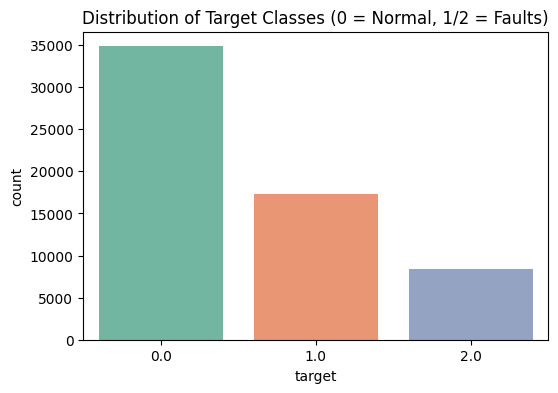

In [11]:
# EDA STEP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("synthetic_scada_pro_7days_time_ordered.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df, hue="target", legend=False, palette="Set2")
plt.title("Distribution of Target Classes (0 = Normal, 1/2 = Faults)")
plt.show()

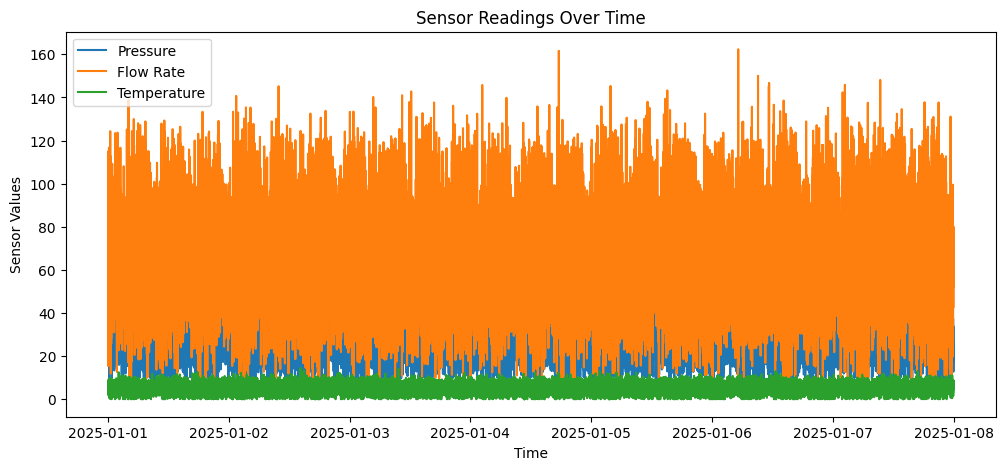

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["timestamp"], df["pressure"], label="Pressure")
plt.plot(df["timestamp"], df["flow_rate"], label="Flow Rate")
plt.plot(df["timestamp"], df["temperature"], label="Temperature")
plt.legend()
plt.title("Sensor Readings Over Time")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.show()

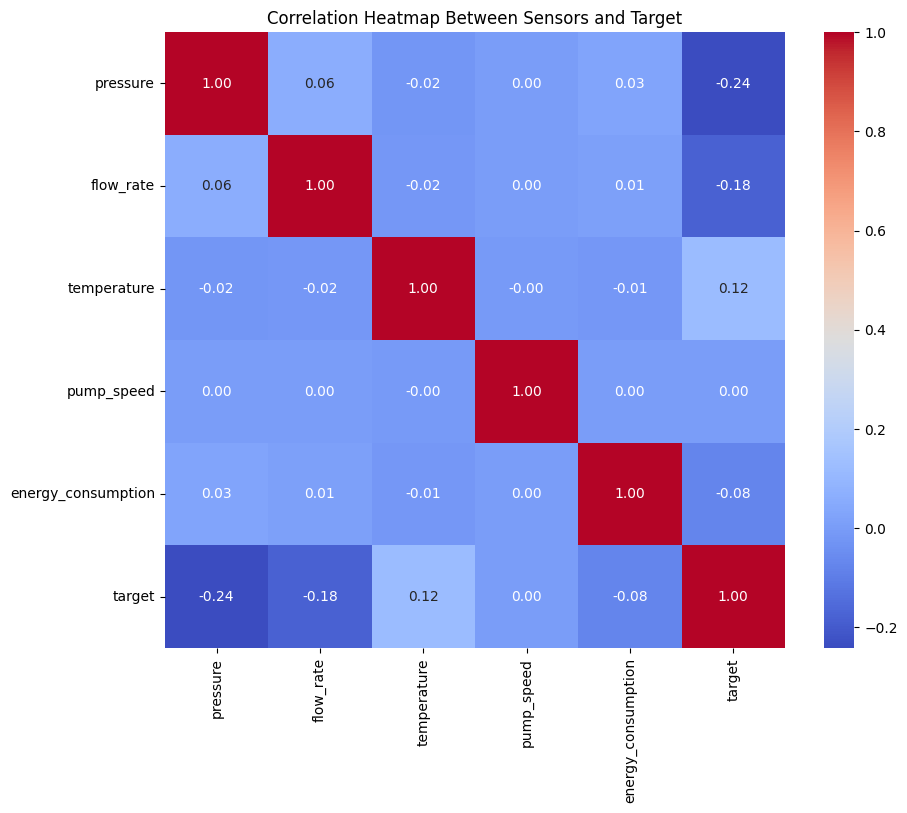

In [13]:
# 3. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(10,8))
sns.heatmap(df[["pressure","flow_rate","temperature","pump_speed","energy_consumption","target"]].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap Between Sensors and Target")
plt.show()

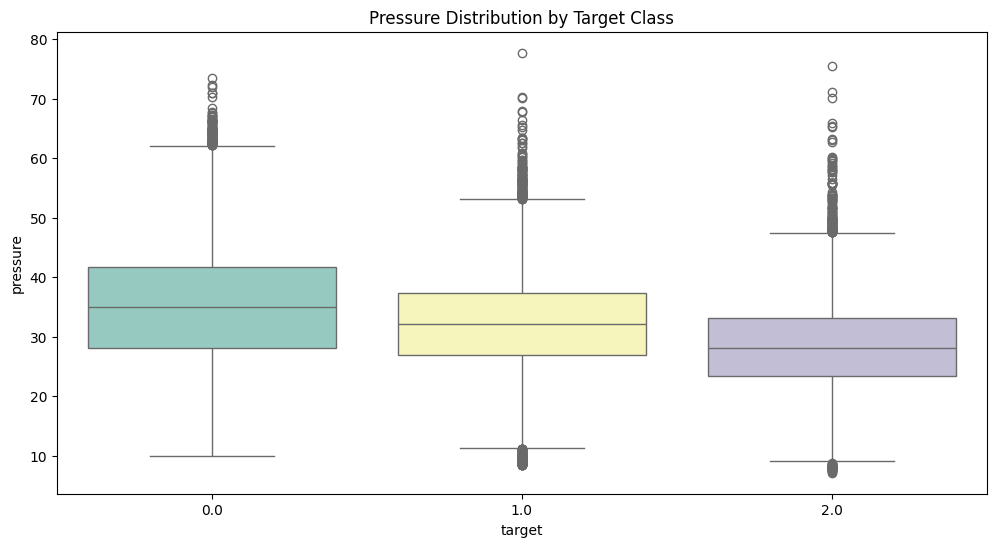

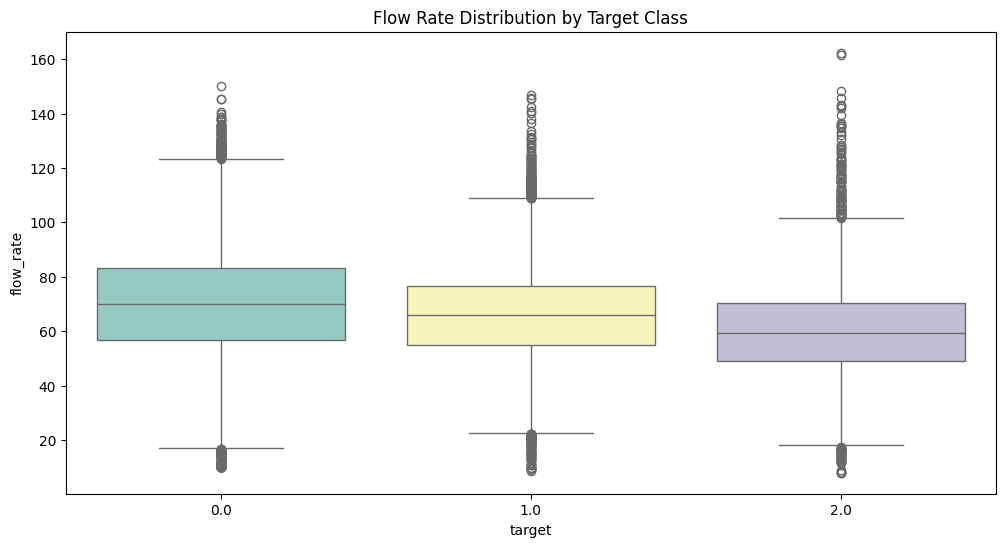

In [17]:
# 4. Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(x="target", y="pressure", data=df, hue="target", palette="Set3", legend=False)
plt.title("Pressure Distribution by Target Class")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x="target", y="flow_rate", data=df, hue="target", palette="Set3", legend=False)
plt.title("Flow Rate Distribution by Target Class")
plt.show()

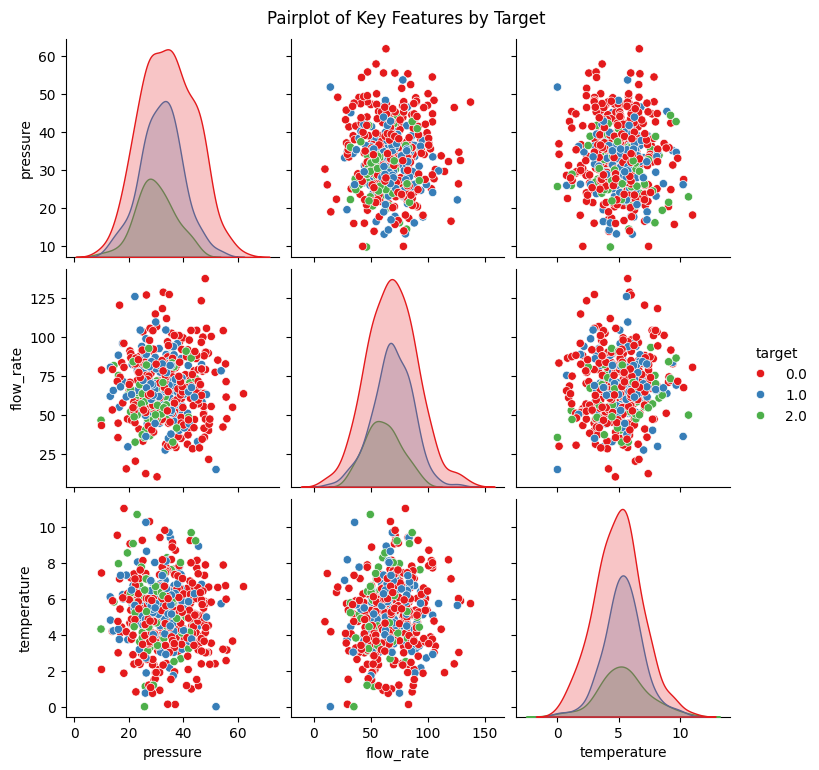

In [18]:
# 5. Pairplot 
sample_df = df.sample(500, random_state=42)
sns.pairplot(sample_df[["pressure","flow_rate","temperature","target"]], hue="target", palette="Set1")
plt.suptitle("Pairplot of Key Features by Target", y=1.02)
plt.show()


In [19]:
# ==========================
# 📊 Key Insights from EDA:
# ==========================

# 1) Target distribution:
#   - Class 0 samples are more frequent compared to Class 1 and Class 2.
#   - This indicates a class imbalance problem that requires handling (e.g., SMOTE).

# 2) Pressure:
#   - Average pressure is higher in faulty states (1 and 2) compared to normal state (0).
#   - This makes sense, as abnormal pressure levels are strong indicators of faults.

# 3) Flow rate:
#   - Class 2 shows higher variance compared to Class 0 and 1.
#   - This suggests unstable flow could be an early warning for certain types of faults.

# 4) Temperature:
#   - Temperatures are generally higher in Class 1 and 2 compared to normal conditions.
#   - Overheating seems to be a major contributor to fault occurrence.

# 5) Energy consumption:
#   - Energy usage increases significantly during faulty states, especially Class 2.
#   - This suggests machines consume more power under abnormal operating conditions.

# 💡 Conclusion:
# - Strong relationships exist between sensor readings (pressure, flow_rate, temperature, energy_consumption)
#   and fault occurrence (target).
# - The next step is Feature Engineering to extract time-based and statistical indicators
#   that enhance the model’s predictive power.


In [ ]:
import pandas as pd

data_path = 'synthetic_scada_pro_7days_time_ordered.csv'  
df = pd.read_csv(data_path)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp').reset_index(drop=True)

seconds_per_row = 10
rows_per_hour = int(3600 / seconds_per_row) 
lag_hours = 4 
lag_rows = lag_hours * rows_per_hour

df['event_future'] = df['event_type'].shift(-lag_rows)

feature_cols = ['timestamp','pressure','flow_rate','temperature','valve_status',
                'pump_state','pump_speed','compressor_state','energy_consumption','alarm_triggered']

df_normal  = df[df['event_future'] == 'normal'][feature_cols].reset_index(drop=True)
df_warning = df[df['event_future'] == 'warning'][feature_cols].reset_index(drop=True)
df_failure = df[df['event_future'] == 'failure'][feature_cols].reset_index(drop=True)


df_normal.to_csv('normal_4h_before.csv', index=False)
df_warning.to_csv('warning_4h_before.csv', index=False)
df_failure.to_csv('failure_4h_before.csv', index=False)

In [ ]:
import pandas as pd

data_path = 'synthetic_scada_pro_7days_time_ordered.csv'  
df = pd.read_csv(data_path)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp').reset_index(drop=True)

seconds_per_row = 10
rows_per_hour = int(3600 / seconds_per_row)  
lag_hours = 2  
lag_rows = lag_hours * rows_per_hour

df['event_future'] = df['event_type'].shift(-lag_rows)

feature_cols = ['timestamp','pressure','flow_rate','temperature','valve_status',
                'pump_state','pump_speed','compressor_state','energy_consumption','alarm_triggered']

df_failure = df[df['event_future'] == 'failure'][feature_cols].reset_index(drop=True)

df_failure.to_csv('failure_2h_before.csv', index=False)